In [1]:
import warnings
from collections import Counter
from typing import Callable, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import scipy
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics, tree
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from metrics_eo import equailized_odds
from objective import Objective
from reprojections import reproject_features_w_regul, reproject_features
from study_reprojection import data_preprocessing

/opt/homebrew/Caskroom/miniforge/base/envs/fair/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
standardize = True
standardize_continuous = True
resample = True
reproject = False
lambda_reproject = False
run_optim_no_fairness = False

train = pd.read_csv('data/heart_train.csv')
val = pd.read_csv('data/heart_val.csv')
test = pd.read_csv('data/heart_test.csv')

# Select only rows with black and white race
train = train.loc[train['Race'].isin(['White', 'Black'])]
val = val.loc[val['Race'].isin(['White', 'Black'])]
test = test.loc[test['Race'].isin(['White', 'Black'])]

categorical_features = [
    "Smoking",
    "AlcoholDrinking",
    "Stroke",
    "DiffWalking",
    "Sex",
    "AgeCategory",
    "Race",
    "Diabetic",
    "PhysicalActivity",
    "GenHealth",
    "Asthma",
    "KidneyDisease",
    "SkinCancer"
]

continuos_features = [
    "BMI",
    "PhysicalHealth",
    "MentalHealth"
]

target_variable = "HeartDisease"

train_processed, train_original, train_target, train_race = data_preprocessing(
    train, categorical_features=categorical_features,
    continuos_features=continuos_features,
    target_variable=target_variable)
val_processed, val_original, val_target, val_race = data_preprocessing(
    val, categorical_features=categorical_features,
    continuos_features=continuos_features,
    target_variable=target_variable)
test_processed, test_original, test_target, test_race = data_preprocessing(
    test, categorical_features=categorical_features,
    continuos_features=continuos_features,
    target_variable=target_variable)

y_train, y_val, y_test = train_target, val_target, test_target

if standardize:
    if standardize_continuous:
        # Scale continuous variables
        mean_ = np.mean(train_processed[continuos_features], axis=0)
        std_ = np.std(train_processed[continuos_features], ddof=1, axis=0)

        train_processed[continuos_features] = (
            train_processed[continuos_features] - mean_) / std_
        val_processed[continuos_features] = (val_processed[continuos_features] - mean_) / std_
        test_processed[continuos_features] = (
            test_processed[continuos_features] - mean_) / std_

    else:
        # Standardize all variables
        mean_ = np.mean(train_processed, axis=0)
        std_ = np.std(train_processed, ddof=1, axis=0)

        train_processed = (train_processed - mean_) / std_
        val_processed = (val_processed - mean_) / std_
        test_processed = (test_processed - mean_) / std_

sampler = optuna.samplers.TPESampler()

# Do random oversampling to make class distribution even
if resample:
    ros = RandomOverSampler(random_state=42)
    train_processed, y_train, = ros.fit_resample(
        train_processed, y_train)

best_params_exp1 = {'criterion': 'gini', 'max_depth': 29, 'min_samples_split': 0.0015208435967915194, 'min_samples_leaf': 0.00010984751659357859}
best_params_exp2 = {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 0.008791657968284442, 'min_samples_leaf': 2.5756722034438575e-05}

model = DecisionTreeClassifier(**best_params_exp2)
model.fit(train_processed, y_train)

val_pred = model.predict(val_processed)
val_pred_proba = model.predict_proba(val_processed)
test_pred = model.predict(test_processed)
test_pred_proba = model.predict_proba(test_processed)

In [3]:
print(Counter(test_pred))
print(Counter(val_pred))

Counter({'No': 26700, 'Yes': 13533})
Counter({'No': 26535, 'Yes': 13580})


In [4]:
# Feature importance
print('Feature importances')
weights = model.feature_importances_
feats_names = model.feature_names_in_
sorted_importance = list(zip(weights.tolist(), feats_names.tolist()))
sorted_importance.sort(key = lambda x: x[0], reverse=True)
sorted_importance[:10]

feature_importances = {}

feature_names = continuos_features + categorical_features

for feature in feature_names:
    feature_importances[feature] = []
    for feature_impotrance in sorted_importance:
        if feature in feature_impotrance[1]:
            feature_importances[feature].append(feature_impotrance[0])
    
for feat, imp in feature_importances.items():
    print(f'{feat} has summed importance {round(np.sum(imp), 5)}')

Feature importances
BMI has summed importance 0.00983
PhysicalHealth has summed importance 0.00482
MentalHealth has summed importance 0.00189
Smoking has summed importance 0.01045
AlcoholDrinking has summed importance 0.00117
Stroke has summed importance 0.04541
DiffWalking has summed importance 0.23482
Sex has summed importance 0.0742
AgeCategory has summed importance 0.35197
Race has summed importance 0.00316
Diabetic has summed importance 0.127
PhysicalActivity has summed importance 0.0
GenHealth has summed importance 0.1255
Asthma has summed importance 0.00167
KidneyDisease has summed importance 0.00737
SkinCancer has summed importance 0.00074


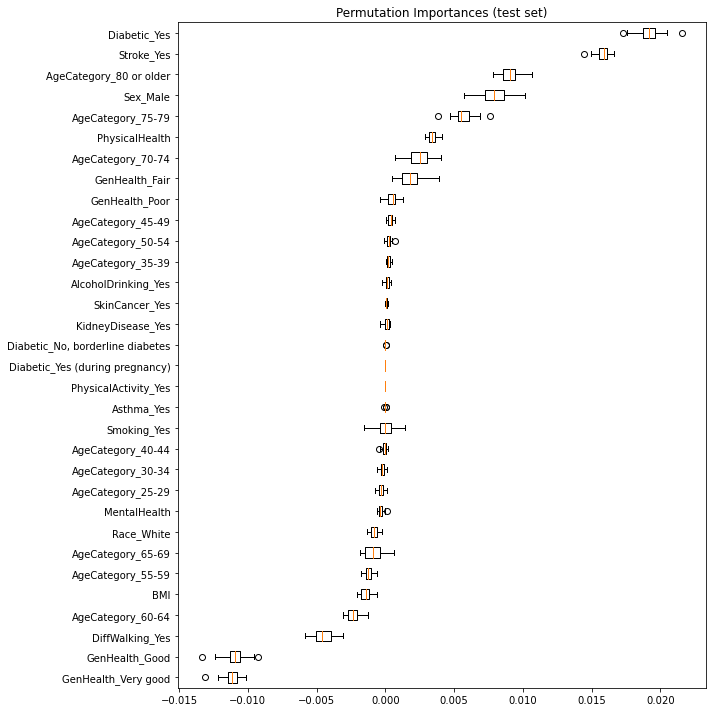

In [6]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model, test_processed, y_test, n_repeats=30, random_state=0)

sorted_idx = result.importances_mean.argsort()
importance_scores = result.importances[sorted_idx].T
fig, ax = plt.subplots(figsize = (10,10))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=test_processed.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

 95%|=================== | 76638/80466 [00:11<00:00]       

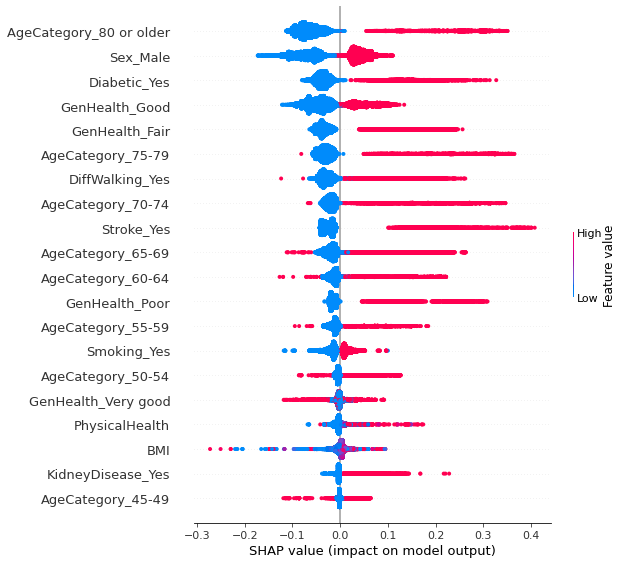

In [5]:
import shap

explainer = shap.TreeExplainer(model, train_processed, model_output="probability")
shap_values = explainer.shap_values(test_processed)
shap.summary_plot(shap_values[1], test_processed, feature_names=train_processed.columns)

In [8]:
len(shap_values)

2